In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [2]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [3]:
data_path = '/tf/notebooks/final-project/data/sample/hein-daily'

In [46]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [6]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

In [2]:
!cat /tf/notebooks/final-project/data/QA/full_descr.txt | wc -l

2914465


In [8]:
# OPEN descr FROM A SAVED FILE (if it was previously saved)
# outdata_path = '/tf/notebooks/final-project/Classification/data'
# descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

37,617 fuzzy match speeches had multiple duplicates. Delete them from the dictionary

In [47]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1020219407
speaker Mr. SYMMS
char_count 68
speakerid 102108021.0
Ethnicity W
word_count 13
NonWhite 0.0
Age_lt_med 0.0
Congress 102
match exact
Party R
date 19920918
State ID
Full Name SYMMS, STEVEN
Age 54.0
Female 0.0
check 1
Chamber S

It took 16.8 seconds to create the dictionary


In [48]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.9634876258550458

In [49]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

283399

### Save descr dictionary

In [233]:
#outdata_path = '/tf/notebooks/final-project/Classification/data'

In [12]:
#pickle.dump(descr, open(os.path.join(outdata_path, 'descr.p'), 'wb'))

In [ ]:
#descr = pickle.load(open(os.path.join(outdata_path, 'descr.p'), 'rb'))

### Data QA

In [12]:
explore_data.get_counts(gender)

,Category,Count
0,-1,64727
1,0,214221
2,1,4451


## Split into train, validate, test

In [50]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [14]:
sum(train_target), sum(val_target), sum(test_target)

(1622, 540, 542)

In [15]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

1747

## CNN

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [16]:
reload(explore_data)
explore_data.get_num_words_per_sample(train)

207.5

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90      100
0  31.0  45.0  68.0  103.0  154.0  207.5  274.0  363.0  503.0  750.7  8435.0


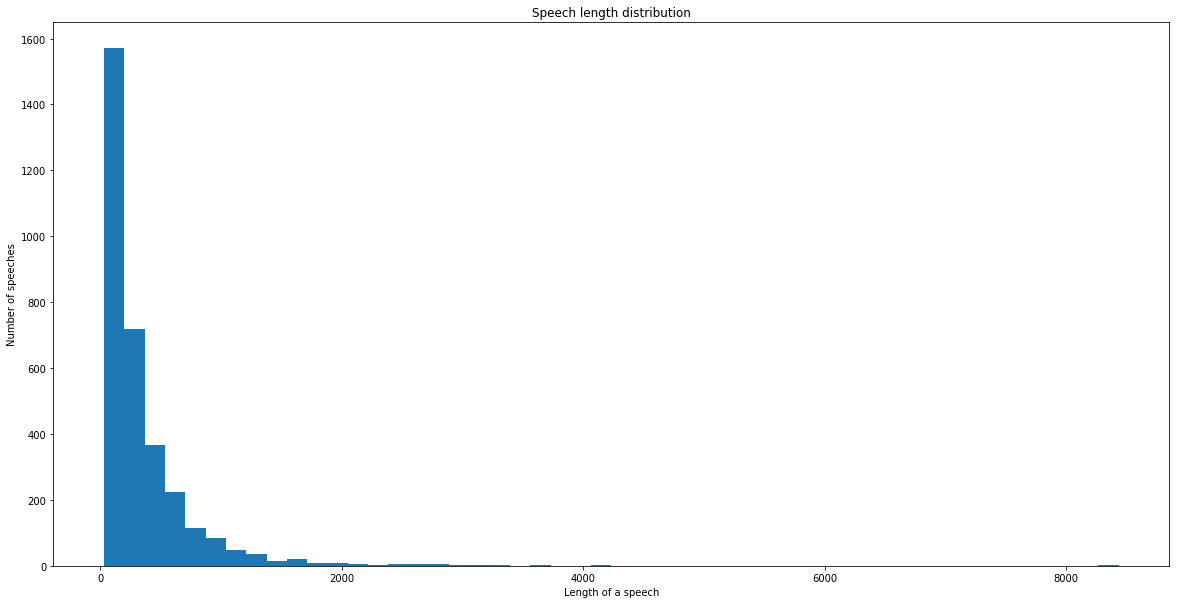

In [17]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

#### OPTIONAL: Split speeches into 100-word chunks

In [207]:
# reload(preprocess_data)
# train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=100)

Original data has 3244 speeches
It was split into 12496 chunks
Checks on ids and target 12496 12496
Original target mean 0.5
New target mean 0.5060819462227913


In [197]:
# val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=100)

Original data has 1080 speeches
It was split into 4252 chunks
Checks on ids and target 4252 4252
Original target mean 0.5
New target mean 0.47765757290686733


In [198]:
# test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=100)

Original data has 1084 speeches
It was split into 4189 chunks
Checks on ids and target 4189 4189
Original target mean 0.5
New target mean 0.5301981379804249


### Tokenize speeches

In [51]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [52]:
reload(preprocess_data)
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {0:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 1.9 seconds to tokenize the data


In [10]:
max(val_vec, key=len).shape

(750,)

In [11]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19984, 19984)

In [20]:
len(train), len(val), len(test)

(3244, 1080, 1084)

In [164]:
#len(train_chunk), len(val_chunk), len(test_chunk)

(12370, 4010, 4089)

In [21]:
len(train_vec), len(val_vec), len(test_vec)

(3244, 1080, 1084)

In [22]:
train_vec[0].shape

(750,)

In [23]:
train_vec[0][-10:]

array([  52, 3587,   52,  906,   63,   14,    5,   14,    9,   48],
      dtype=int32)

In [24]:
train[0]

'Mr. Speaker. I want to compliment the gentleman from California for his comments. I think one of the things that he and the gentleman from Wisconsin were pointing out is that they had some perfecting punendments to the Commission that would have made it better. I think some of the things that people worried about were the calendar days rather than legislative days. the November 15 date. the two Houses having to turn it down. and so forth. That really did make it look a little suspicious. I understand the gentleman being angry about people portraying it as an automatic pay increase. but I think when it was put in both reconciliation and the supplemental with those kinds of things it did come across that way. and it is really too bad. The gentleman is correct. This must be argued openly. It must be argued out front. It must be dealt with by this body. There is no way to find some magic pay fairy who is going to say. "Here. take it. you have to have it. even if you do not want it." I thi

In [27]:
#train_chunk[0]

In [25]:
for word in train[0].split()[-10:]:
    word = re.sub(r'[^\w\s]','',word)
    print(word, word_index[word])

can 52
testify 3587
can 52
talk 906
about 63
it 14
and 5
it 14
is 9
there 48


In [26]:
len(word_index)

40496

### Saving processed files

In [54]:
token_path = '/tf/notebooks/final-project/Classification/data/tokenized'

In [56]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [57]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [58]:
len(train_vec), len(val_vec), len(test_vec)

(3244, 1080, 1084)

In [59]:
del descr

## CNN Models

In [17]:
logs_base_dir = "/tf/notebooks/final-project/Classification/logs"

In [19]:
cnn_model_params = {
    'model': 'cnn',
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 100,
    'kernel_size': 3,
    'pool_size': 1,
    'max_num_words': TOP_K,
    'use_pretrained_embedding': False,
    'is_embedding_trainable': True,
    'glove_dir': '/tf/notebooks/final-project/data'
}

In [20]:
# train_shuffle = np.random.permutation(np.arange(len(train_target_chunk)))
# train_vec = train_vec[train_shuffle]
# train_target_chunk = np.array(train_target_chunk, dtype=int)[train_shuffle]

In [21]:
#len(train_target_chunk), len(train_target)

In [22]:
len(word_index)

40496

In [23]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), word_index, logs_base_dir, **cnn_model_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 3244 samples, validate on 1080 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 10s - loss: 0.6924 - acc: 0.5188 - val_loss: 0.6905 - val_acc: 0.5037
Epoch 2/1000
 - 10s - loss: 0.6868 - acc: 0.5684 - val_loss: 0.6742 - val_acc: 0.6713
Epoch 3/1000
 - 10s - loss: 0.6576 - acc: 0.6421 - val_loss: 0.6152 - val_acc: 0.6574
Epoch 4/1000
 - 10s - loss: 0.6139 - acc: 0.6625 - val_loss: 0.6004 - val_acc: 0.6870
Epoch 5/1000
 - 10s - loss: 0.5854 - acc: 0.7016 - val_loss: 0.5898 - val_acc: 0.6907
Epoch 6/1000
 - 9s - loss: 0.5428 - acc: 0.7361 - val_loss: 0.5877 - val_acc: 0.6685
Epoch 7/1000
 - 9s - loss: 0.4610 - acc: 0.7956 - val_loss: 0.5998 - val_acc: 0.6963
Epoch 8/1000
 - 10s - loss: 0.3451 - ac

In [61]:
sepcnn_model_params = {
    'model': 'sepcnn',
    'blocks': 2,
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 3,
    'pool_size': 3,
    'max_num_words': TOP_K,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': '/tf/notebooks/final-project/data'
}

In [62]:
reload(train_model)
history_sep, train_pred_probs_sep, val_pred_probs_sep = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), word_index, logs_base_dir, **sepcnn_model_params)

Found 400000 word vectors.
It took 16.7 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.0 seconds
Train on 3244 samples, validate on 1080 samples
Epoch 1/1000
 - 10s - loss: 0.6933 - acc: 0.5034 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/1000
 - 9s - loss: 0.6931 - acc: 0.5028 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/1000
 - 9s - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/1000
 - 10s - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6932 - val_acc: 0.5000
Validation accuracy: 0.5, loss: 0.6931798842218188


### Clean up space/save outputs

In [24]:
del train, train_ids, train_pred_probs, train_target, train_vec

In [25]:
probs_path = '/tf/notebooks/final-project/Classification/data/cnn/gender'

In [26]:
with open(os.path.join(probs_path, 'val_pred_probs'), 'wb') as fp:
    pickle.dump(val_pred_probs, fp)

In [27]:
with open(os.path.join(probs_path, 'val_pred_probs'), 'rb') as fp:
    val_pred_probs = pickle.load(fp)

## Model evaluation

In [28]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

716

In [29]:
val_preds.shape, len(val_target)

((1080, 1), 1080)

Confusion matrix, without normalization
[[366 174]
 [190 350]]


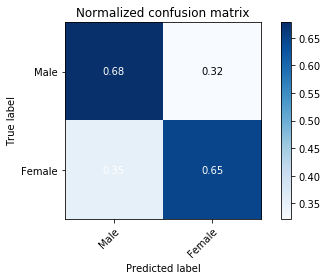

In [30]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

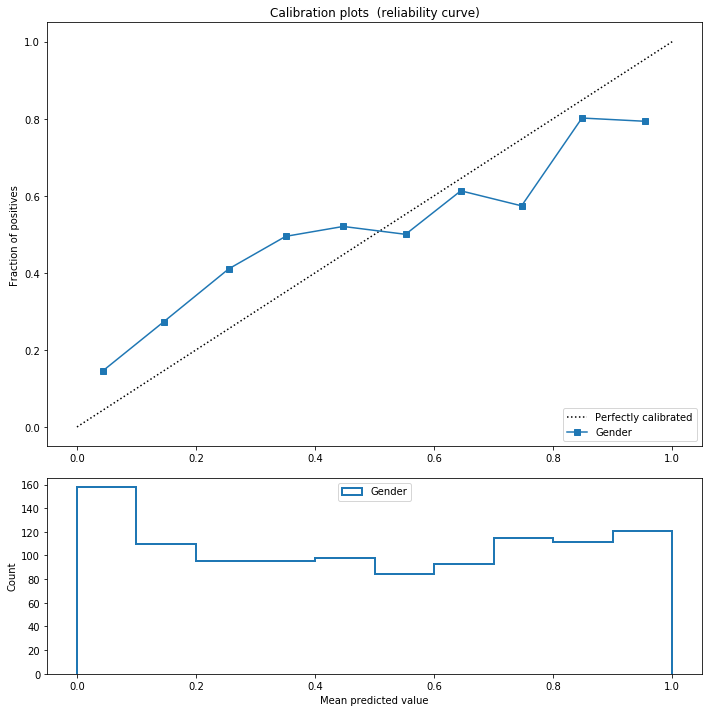

In [31]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [32]:
descr_df = pd.read_csv('/tf/notebooks/final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1080, 16)

In [33]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5       0.056481  52.249074  0.494444   0.710185    343.353704


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.61,0.97,1.03,0.90,0.63,0.88
0.6,1.02,0.78,0.98,0.93,1.18,1.29
1.0,1.40,1.13,0.98,1.14,1.31,1.01


In [34]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
senator 	 37.6
the senator 	 35.4
senator from 	 34.7
chairman rise 	 25.3
mr president 	 23.6
women 	 21.3
mr chairman 	 20.2
mr speaker 	 20.1
rise in 	 19.5
the distinguished 	 18.6


bin,1,2,3
chairman rise,2.0,5.0,46.0
mr chairman,61.0,42.0,187.0
mr president,360.0,71.0,46.0
mr speaker,176.0,143.0,312.0
rise in,16.0,19.0,72.0
senator,337.0,31.0,33.0
senator from,171.0,7.0,3.0
the distinguished,58.0,5.0,7.0
the senator,177.0,6.0,6.0
women,8.0,10.0,175.0


In [35]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True negative (Predicted prob: 0.09):

date                   19810718
char_count                  206
word_count                   35
speakerid           9.71069e+07
Party                         D
Congress                     97
Chamber                       S
State                        WI
Ethnicity                     W
Age                          67
Age_lt_med                    0
NonWhite                      0
Female                        0
speaker            Mr. PROXMIRE
Full Name     PROXMIRE, WILLIAM
match                     exact
Name: 970059307, dtype: object

 Let us take this alleged relation to exports. An American citizen is living in Tokyo and working for Toyota actively promoting the export of Toyotas to the United States. Would he qualify for the exclusion?
--------------------

False positive (Predicted prob: 0.95):

date                     19820317
char_count                    308
word_count                     50
speakerid             9.71089e+07
Party     

#### Run the following test on a random subset of the validation sample

In [37]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.3037037037037037

In [38]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(328, 328, 328)

In [39]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the senator from
the united states
would like to
the committee on
the gentleman from
in order to
thank the gentleman
members of the
one of the
in this country
--------------------

In 0.6 bin top 10 ngrams:

the united states
would like to
the soviet union
the gentleman from
the chairman of
of the senate
it is not
chairman of the
because of the
the number of
--------------------

In 1.0 bin top 10 ngrams:

the united states
would like to
the gentleman from
the american people
my colleagues to
the federal government
the social security
percent of the
thank the gentleman
members of the
--------------------


In [36]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(3, 4))


Top 10 ngrams by differentiating score:
the senator from 	 29.0
mr chairman rise 	 25.3
mr chairman rise in 	 23.7
chairman rise in 	 23.7
chairman rise in support 	 16.7
rise in support 	 16.4
rise in support of 	 15.7
in support of 	 15.0
my colleagues to 	 12.9
mr president ask 	 12.6


bin,1,2,3
chairman rise in,1.0,5.0,42.0
chairman rise in support,1.0,1.0,26.0
in support of,19.0,12.0,65.0
mr chairman rise,2.0,5.0,46.0
mr chairman rise in,1.0,5.0,42.0
mr president ask,34.0,2.0,7.0
my colleagues to,17.0,14.0,59.0
rise in support,11.0,6.0,49.0
rise in support of,11.0,6.0,48.0
the senator from,133.0,3.0,2.0
